In [76]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import seaborn as sns
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display
import numpy as np
import pandas as pd
from pathlib import Path
import copy
import sys

project_path = Path().cwd().parent.parent
data_path = project_path / 'dataset'
src_path = project_path / 'python' / 'src'
model_path = project_path / 'model'

sys.path.append(str(src_path))

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import os
import torch
from torch import device
import glob
import datetime
import numpy as np
import shutil
from pathlib import Path
import pickle
import argparse

def normalization(seqData,max,min):
    return (seqData -min)/(max-min)

def standardization(seqData,mean,std):
    return (seqData-mean)/std

def reconstruct(seqData,mean,std):
    return seqData*std+mean

class PickleDataLoad(object):
    def __init__(self, path, n_obs=2, augment_data=False):
        self.augment_data=augment_data
        self.n_obs = n_obs
        self.trainData = self.preprocessing(Path(path, 'airbus_train.csv'),train=True)
        self.testData = self.preprocessing(Path(path, 'airbus_train.csv'),train=False)

    def augmentation(self,data,noise_ratio=0.05,noise_interval=0.0005,max_length=100000):
        noiseSeq = torch.randn(data.size())
        augmentedData = data.clone()
        for i in np.arange(0, noise_ratio, noise_interval):
            scaled_noiseSeq = noise_ratio * self.std.expand_as(data) * noiseSeq
            augmentedData = torch.cat([augmentedData, data + scaled_noiseSeq], dim=0)
            if len(augmentedData) > max_length:
                augmentedData = augmentedData[:max_length]
                break

        return augmentedData
    
    def batchify(self,args,data, bsz):
        nbatch = data.size(0) // bsz
        trimmed_data = data.narrow(0,0,nbatch * bsz)
        batched_data = trimmed_data.contiguous().view(bsz, -1, trimmed_data.size(-1)).transpose(0,1)
        batched_data = batched_data.to(args.device)
        return batched_data

    def preprocessing(self, path, train=True):
        """ Read, Standardize, Augment """

        with open(str(path), 'rb') as f:
            data = torch.FloatTensor(np.loadtxt(path, delimiter= ' ').T)
            
        total_observations = data.shape[1]
        obs = np.random.choice(list(range(total_observations)), self.n_obs)
        data = data[:, obs]
        
        if train:
            self.mean = data.mean(dim=0)
            self.std= data.std(dim=0)
            self.length = len(data)
            self.train_obs = obs
            if self.augment_data:
                data = self.augmentation(data)
        else:
            self.test_obs = obs
            if self.augment_data:
                data = self.augmentation(data)

        data = standardization(data,self.mean,self.std)

        return data

## Training

In [219]:
class Args():
    data = 'airbus'
    filename= 'airbus.csv'
    model = 'LSTM'
    augment = False
    emsize = 100
    nhid = 100
    nlayers = 4
    res_connection = True
    lr = 0.0002
    weight_decay = 1e-4
    clip = 10.
    epochs = 30
    batch_size = 100
    bptt = 50
    eval_batch_size = 100
    teacher_forcing_ratio = 0.7
    dropout = 0.2
    tied = False                    # tie the word embedding and softmax weights (deprecated)
    seed = 1111
    device = 'cuda'
    log_interval = 10
    save_interval = 10
    save_fig = True
    resume = False
    pretrained = False
    prediction_window_size = 100
    compensate = False
    beta=1.0
    
args = Args()

In [203]:
Timeseries_train = PickleDataLoad(path=data_path, augment_data=False, n_obs=4)

In [222]:
train_dataset = Timeseries_train.batchify(args,Timeseries_train.trainData, bsz=args.batch_size)
test_dataset = Timeseries_valid.batchify(args,Timeseries_train.trainData, bsz=args.eval_batch_size)
gen_dataset = Timeseries_valid.batchify(args,Timeseries_train.trainData, 1)

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from model import RNNPredictor
from anomalyDetector import fit_norm_distribution_param
from anomalyDetector import anomalyScore
from anomalyDetector import get_precision_recall
import time

###############################################################################
# Build the model
###############################################################################
feature_dim = Timeseries_train.trainData.size(1)
model = RNNPredictor(rnn_type = args.model,
                           enc_inp_size=feature_dim,
                           rnn_inp_size = args.emsize,
                           rnn_hid_size = args.nhid,
                           dec_out_size=feature_dim,
                           nlayers = args.nlayers,
                           dropout = args.dropout,
                           tie_weights= args.tied,
                           res_connection=args.res_connection).to(args.device)
optimizer = optim.Adam(model.parameters(), lr= args.lr,weight_decay=args.weight_decay)
criterion = nn.MSELoss()
###############################################################################
# Training code
###############################################################################
def get_batch(args,source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len] # [ seq_len * batch_size * feature_size ]
    target = source[i+1:i+1+seq_len] # [ (seq_len x batch_size x feature_size) ]
    return data, target

def generate_output(args,epoch, model, gen_dataset, disp_uncertainty=True,startPoint=500, endPoint=3500):
    if args.save_fig:
        # Turn on evaluation mode which disables dropout.
        model.eval()
        hidden = model.init_hidden(1)
        outSeq = []
        upperlim95 = []
        lowerlim95 = []
        with torch.no_grad():
            for i in range(endPoint):
                if i>=startPoint:
                    # if disp_uncertainty and epoch > 40:
                    #     outs = []
                    #     model.train()
                    #     for i in range(20):
                    #         out_, hidden_ = model.forward(out+0.01*Variable(torch.randn(out.size())).cuda(),hidden,noise=True)
                    #         outs.append(out_)
                    #     model.eval()
                    #     outs = torch.cat(outs,dim=0)
                    #     out_mean = torch.mean(outs,dim=0) # [bsz * feature_dim]
                    #     out_std = torch.std(outs,dim=0) # [bsz * feature_dim]
                    #     upperlim95.append(out_mean + 2.58*out_std/np.sqrt(20))
                    #     lowerlim95.append(out_mean - 2.58*out_std/np.sqrt(20))

                    out, hidden = model.forward(out, hidden)

                    #print(out_mean,out)

                else:
                    out, hidden = model.forward(gen_dataset[i].unsqueeze(0), hidden)
                outSeq.append(out.data.cpu()[0][0].unsqueeze(0))


        outSeq = torch.cat(outSeq,dim=0) # [seqLength * feature_dim]

        target= reconstruct(gen_dataset.cpu(), Timeseries_train.mean, Timeseries_train.std)
        outSeq = reconstruct(outSeq, Timeseries_train.mean, Timeseries_train.std)
        # if epoch>40:
        #     upperlim95 = torch.cat(upperlim95, dim=0)
        #     lowerlim95 = torch.cat(lowerlim95, dim=0)
        #     upperlim95 = preprocess_data.reconstruct(upperlim95.data.cpu().numpy(),TimeseriesData.mean,TimeseriesData.std)
        #     lowerlim95 = preprocess_data.reconstruct(lowerlim95.data.cpu().numpy(),TimeseriesData.mean,TimeseriesData.std)

        plt.figure(figsize=(15,5))
        for i in range(target.size(-1)):
            plt.plot(target[:,:,i].numpy(), label='Target'+str(i),
                     color='black', marker='.', linestyle='--', markersize=1, linewidth=0.5)
            plt.plot(range(startPoint), outSeq[:startPoint,i].numpy(), label='1-step predictions for target'+str(i),
                     color='green', marker='.', linestyle='--', markersize=1.5, linewidth=1)
            # if epoch>40:
            #     plt.plot(range(startPoint, endPoint), upperlim95[:,i].numpy(), label='upperlim'+str(i),
            #              color='skyblue', marker='.', linestyle='--', markersize=1.5, linewidth=1)
            #     plt.plot(range(startPoint, endPoint), lowerlim95[:,i].numpy(), label='lowerlim'+str(i),
            #              color='skyblue', marker='.', linestyle='--', markersize=1.5, linewidth=1)
            plt.plot(range(startPoint, endPoint), outSeq[startPoint:,i].numpy(), label='Recursive predictions for target'+str(i),
                     color='blue', marker='.', linestyle='--', markersize=1.5, linewidth=1)

        plt.xlim([startPoint-500, endPoint])
        plt.xlabel('Index',fontsize=15)
        plt.ylabel('Value',fontsize=15)
        plt.title('Time-series Prediction on ' + args.data + ' Dataset', fontsize=18, fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.text(startPoint-500+10, target.min(), 'Epoch: '+str(epoch),fontsize=15)
        save_dir = (model_path / 'checkpoint' / 'airbus').with_suffix('').joinpath('fig_prediction')
        save_dir.mkdir(parents=True,exist_ok=True)
        plt.savefig(save_dir.joinpath('fig_epoch'+str(epoch)).with_suffix('.png'))
        #plt.show()
        plt.close()
        return outSeq

    else:
        pass



def evaluate_1step_pred(args, model, test_dataset):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0
    with torch.no_grad():
        hidden = model.init_hidden(args.eval_batch_size)
        for nbatch, i in enumerate(range(0, test_dataset.size(0) - 1, args.bptt)):

            inputSeq, targetSeq = get_batch(args,test_dataset, i)
            outSeq, hidden = model.forward(inputSeq, hidden)

            loss = criterion(outSeq.view(args.batch_size,-1), targetSeq.view(args.batch_size,-1))
            hidden = model.repackage_hidden(hidden)
            total_loss+= loss.item()

    return total_loss / nbatch

def train(args, model, train_dataset,epoch):

    with torch.enable_grad():
        # Turn on training mode which enables dropout.
        model.train()
        total_loss = 0
        start_time = time.time()
        hidden = model.init_hidden(args.batch_size)
        for batch, i in enumerate(range(0, train_dataset.size(0) - 1, args.bptt)):
            inputSeq, targetSeq = get_batch(args,train_dataset, i)
            # inputSeq: [ seq_len * batch_size * feature_size ]
            # targetSeq: [ seq_len * batch_size * feature_size ]

            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden = model.repackage_hidden(hidden)
            hidden_ = model.repackage_hidden(hidden)
            optimizer.zero_grad()

            '''Loss1: Free running loss'''
            outVal = inputSeq[0].unsqueeze(0)
            outVals=[]
            hids1 = []
            for i in range(inputSeq.size(0)):
                outVal, hidden_, hid = model.forward(outVal, hidden_,return_hiddens=True)
                outVals.append(outVal)
                hids1.append(hid)
            outSeq1 = torch.cat(outVals,dim=0)
            hids1 = torch.cat(hids1,dim=0)
            loss1 = criterion(outSeq1.view(args.batch_size,-1), targetSeq.view(args.batch_size,-1))

            '''Loss2: Teacher forcing loss'''
            outSeq2, hidden, hids2 = model.forward(inputSeq, hidden, return_hiddens=True)
            loss2 = criterion(outSeq2.view(args.batch_size, -1), targetSeq.view(args.batch_size, -1))

            '''Loss3: Simplified Professor forcing loss'''
            loss3 = criterion(hids1.view(args.batch_size,-1), hids2.view(args.batch_size,-1).detach())

            '''Total loss = Loss1+Loss2+Loss3'''
            loss = loss1+loss2+loss3
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()

            total_loss += loss.item()

            if batch % args.log_interval == 0 and batch > 0:
                cur_loss = total_loss / args.log_interval
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.4f} | '
                      'loss {:5.2f} '.format(
                    epoch, batch, len(train_dataset) // args.bptt,
                                  elapsed * 1000 / args.log_interval, cur_loss))
                total_loss = 0
                start_time = time.time()

def evaluate(args, model, test_dataset):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    with torch.no_grad():
        total_loss = 0
        hidden = model.init_hidden(args.eval_batch_size)
        nbatch = 1
        for nbatch, i in enumerate(range(0, test_dataset.size(0) - 1, args.bptt)):
            inputSeq, targetSeq = get_batch(args,test_dataset, i)
            # inputSeq: [ seq_len * batch_size * feature_size ]
            # targetSeq: [ seq_len * batch_size * feature_size ]
            hidden_ = model.repackage_hidden(hidden)
            '''Loss1: Free running loss'''
            outVal = inputSeq[0].unsqueeze(0)
            outVals=[]
            hids1 = []
            for i in range(inputSeq.size(0)):
                outVal, hidden_, hid = model.forward(outVal, hidden_,return_hiddens=True)
                outVals.append(outVal)
                hids1.append(hid)
            outSeq1 = torch.cat(outVals,dim=0)
            hids1 = torch.cat(hids1,dim=0)
            loss1 = criterion(outSeq1.view(args.batch_size,-1), targetSeq.view(args.batch_size,-1))

            '''Loss2: Teacher forcing loss'''
            outSeq2, hidden, hids2 = model.forward(inputSeq, hidden, return_hiddens=True)
            loss2 = criterion(outSeq2.view(args.batch_size, -1), targetSeq.view(args.batch_size, -1))

            '''Loss3: Simplified Professor forcing loss'''
            loss3 = criterion(hids1.view(args.batch_size,-1), hids2.view(args.batch_size,-1).detach())

            '''Total loss = Loss1+Loss2+Loss3'''
            loss = loss1+loss2+loss3

            total_loss += loss.item()

    return total_loss / (nbatch+1)


# Loop over epochs.
if args.resume or args.pretrained:
    print("=> loading checkpoint ")
    checkpoint = torch.load(str((data_path / 'checkpoint' / 'airbus').with_suffix('.pth')))
    args, start_epoch, best_val_loss = model.load_checkpoint(args,checkpoint,feature_dim)
    optimizer.load_state_dict((checkpoint['optimizer']))
    del checkpoint
    epoch = start_epoch
    print("=> loaded checkpoint")
else:
    epoch = 1
    start_epoch = 1
    best_val_loss = float('inf')
    print("=> Start training from scratch")
print('-' * 89)
print(args)
print('-' * 89)

if not args.pretrained:
    # At any point you can hit Ctrl + C to break out of training early.
    try:
        for epoch in range(start_epoch, args.epochs+1):

            epoch_start_time = time.time()
            train(args,model,train_dataset,epoch)
            val_loss = evaluate(args,model,test_dataset)
            print('-' * 89)
            print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.4f} | '.format(epoch, (time.time() - epoch_start_time),                                                                                        val_loss))
            print('-' * 89)

            generate_output(args,epoch,model,gen_dataset,startPoint=1500)

            if epoch%args.save_interval==0:
                # Save the model if the validation loss is the best we've seen so far.
                is_best = val_loss < best_val_loss
                best_val_loss = min(val_loss, best_val_loss)
                model_dictionary = {'epoch': epoch,
                                    'best_loss': best_val_loss,
                                    'state_dict': model.state_dict(),
                                    'optimizer': optimizer.state_dict(),
                                    'args':args
                                    }
                model.save_checkpoint(model_dictionary, is_best)

    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early')


# Calculate mean and covariance for each channel's prediction errors, and save them with the trained model
print('=> calculating mean and covariance')
means, covs = list(),list()
train_dataset = Timeseries_train.batchify(args, Timeseries_train.trainData, bsz=1)
for channel_idx in range(model.enc_input_size):
    mean, cov = fit_norm_distribution_param(args,model,train_dataset[:Timeseries_train.length],channel_idx)
    means.append(mean), covs.append(cov)
model_dictionary = {'epoch': max(epoch,start_epoch),
                    'best_loss': best_val_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'args': args,
                    'means': means,
                    'covs': covs
                    }
model.save_checkpoint(model_dictionary, True)
print('-' * 89)

=> Start training from scratch
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| epoch   1 |    10/   12 batches | ms/batch 141.4587 | loss  2.86 
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.08s | valid loss 2.4491 | 
-----------------------------------------------------------------------------------------
| epoch   2 |    10/   12 batches | ms/batch 139.8496 | loss  2.68 
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  2.07s | valid loss 2.3521 | 
-----------------------------------------------------------------------------------------
| epoch   3 |    10/   12 batches | ms/batch 137.4171 | loss  2.54 
-----------------------------------------------------------------------------------------
| end of epoch   3 | 

## Prediction

In [198]:
checkpoint = torch.load(str((model_path / 'checkpoint' / 'save' / 'airbus' / 'checkpoint' / 'airbus').with_suffix('.pth')))

train_dataset = Timeseries_train.batchify(args,Timeseries_train.trainData[:Timeseries_train.length], bsz=1)
test_dataset = Timeseries_train.batchify(args,Timeseries_train.testData, bsz=1)

In [199]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from model import RNNPredictor
from anomalyDetector import fit_norm_distribution_param
from anomalyDetector import anomalyScore
from anomalyDetector import get_precision_recall



###############################################################################
# Build the model
###############################################################################
nfeatures = Timeseries_train.trainData.size(-1)
model = RNNPredictor(rnn_type = args.model,
                           enc_inp_size=nfeatures,
                           rnn_inp_size = args.emsize,
                           rnn_hid_size = args.nhid,
                           dec_out_size=nfeatures,
                           nlayers = args.nlayers,
                           res_connection=args.res_connection).to(args.device)
model.load_state_dict(checkpoint['state_dict'])
#del checkpoint

scores, predicted_scores, precisions, recalls, f_betas = list(), list(), list(), list(), list()
targets, mean_predictions, oneStep_predictions, Nstep_predictions = list(), list(), list(), list()
try:
    # For each channel in the dataset
    for channel_idx in range(nfeatures):
        ''' 1. Load mean and covariance if they are pre-calculated, if not calculate them. '''
        # Mean and covariance are calculated on train dataset.
        if 'means' in checkpoint.keys() and 'covs' in checkpoint.keys():
            print('=> loading pre-calculated mean and covariance')
            mean, cov = checkpoint['means'][channel_idx], checkpoint['covs'][channel_idx]
        else:
            print('=> calculating mean and covariance')
            mean, cov = fit_norm_distribution_param(args, model, train_dataset, channel_idx=channel_idx)

        ''' 2. Train anomaly score predictor using support vector regression (SVR). (Optional) '''
        # An anomaly score predictor is trained
        # given hidden layer output and the corresponding anomaly score on train dataset.
        # Predicted anomaly scores on test dataset can be used for the baseline of the adaptive threshold.
        if args.compensate:
            print('=> training an SVR as anomaly score predictor')
            train_score, _, _, hiddens, _ = anomalyScore(args, model, train_dataset, mean, cov, channel_idx=channel_idx)
            score_predictor = GridSearchCV(SVR(), cv=5,param_grid={"C": [1e0, 1e1, 1e2],"gamma": np.logspace(-1, 1, 3)})
            score_predictor.fit(torch.cat(hiddens,dim=0).numpy(), train_score.cpu().numpy())
        else:
            score_predictor=None

        ''' 3. Calculate anomaly scores'''
        # Anomaly scores are calculated on the test dataset
        # given the mean and the covariance calculated on the train dataset
        print('=> calculating anomaly scores')
        score, sorted_prediction, sorted_error, _, predicted_score = anomalyScore(args, model, test_dataset, mean, cov,
                                                                                  score_predictor=score_predictor,
                                                                                  channel_idx=channel_idx)

        ''' 4. Evaluate the result '''
        # The obtained anomaly scores are evaluated by measuring precision, recall, and f_beta scores
        # The precision, recall, f_beta scores are are calculated repeatedly,
        # sampling the threshold from 1 to the maximum anomaly score value, either equidistantly or logarithmically.
#         print('=> calculating precision, recall, and f_beta')
#         precision, recall, f_beta = get_precision_recall(args, score, num_samples=1000, beta=args.beta,
#                                                          label=TimeseriesData.testLabel.to(args.device))
#         print('data: ',args.data,' filename: ',args.filename,
#               ' f-beta (no compensation): ', f_beta.max().item(),' beta: ',args.beta)
#         if args.compensate:
#             precision, recall, f_beta = get_precision_recall(args, score, num_samples=1000, beta=args.beta,
#                                                              label=TimeseriesData.testLabel.to(args.device),
#                                                              predicted_score=predicted_score)
#             print('data: ',args.data,' filename: ',args.filename,
#                   ' f-beta    (compensation): ', f_beta.max().item(),' beta: ',args.beta)


#         target = reconstruct(test_dataset.cpu()[:, 0, channel_idx],
#                                              Timeseries_train.mean[channel_idx],
#                                              Timeseries_train.std[channel_idx]).numpy()
#         mean_prediction = reconstruct(sorted_prediction.mean(dim=1).cpu(),
#                                                       Timeseries_train.mean[channel_idx],
#                                                       Timeseries_train.std[channel_idx]).numpy()
#         oneStep_prediction = reconstruct(sorted_prediction[:, -1].cpu(),
#                                                          Timeseries_train.mean[channel_idx],
#                                                          Timeseries_train.std[channel_idx]).numpy()
#         Nstep_prediction = reconstruct(sorted_prediction[:, 0].cpu(),
#                                                        Timeseries_train.mean[channel_idx],
#                                                        Timeseries_train.std[channel_idx]).numpy()
#         sorted_errors_mean = sorted_error.abs().mean(dim=1).cpu()
#         sorted_errors_mean *= Timeseries_train.std[channel_idx]
#         sorted_errors_mean = sorted_errors_mean.numpy()
#         score = score.cpu()
#         scores.append(score), targets.append(targets), predicted_scores.append(predicted_score)
#         mean_predictions.append(mean_prediction), oneStep_predictions.append(oneStep_prediction)
#         Nstep_predictions.append(Nstep_prediction)
#         precisions.append(precision), recalls.append(recall), f_betas.append(f_beta)


#         if args.save_fig:
#             save_dir = Path('result',args.data,args.filename).with_suffix('').joinpath('fig_detection')
#             save_dir.mkdir(parents=True,exist_ok=True)
#             plt.plot(precision.cpu().numpy(),label='precision')
#             plt.plot(recall.cpu().numpy(),label='recall')
#             plt.plot(f_beta.cpu().numpy(), label='f1')
#             plt.legend()
#             plt.xlabel('Threshold (log scale)')
#             plt.ylabel('Value')
#             plt.title('Anomaly Detection on ' + args.data + ' Dataset', fontsize=18, fontweight='bold')
#             plt.savefig(str(save_dir.joinpath('fig_f_beta_channel'+str(channel_idx)).with_suffix('.png')))
#             plt.close()


#             fig, ax1 = plt.subplots(figsize=(15,5))
#             ax1.plot(target,label='Target',
#                      color='black',  marker='.', linestyle='--', markersize=1, linewidth=0.5)
#             ax1.plot(mean_prediction, label='Mean predictions',
#                      color='purple', marker='.', linestyle='--', markersize=1, linewidth=0.5)
#             ax1.plot(oneStep_prediction, label='1-step predictions',
#                      color='green', marker='.', linestyle='--', markersize=1, linewidth=0.5)
#             ax1.plot(Nstep_prediction, label=str(args.prediction_window_size) + '-step predictions',
#                      color='blue', marker='.', linestyle='--', markersize=1, linewidth=0.5)
#             ax1.plot(sorted_errors_mean,label='Absolute mean prediction errors',
#                      color='orange', marker='.', linestyle='--', markersize=1, linewidth=1.0)
#             ax1.legend(loc='upper left')
#             ax1.set_ylabel('Value',fontsize=15)
#             ax1.set_xlabel('Index',fontsize=15)
#             ax2 = ax1.twinx()
#             ax2.plot(score.numpy().reshape(-1, 1), label='Anomaly scores from \nmultivariate normal distribution',
#                      color='red', marker='.', linestyle='--', markersize=1, linewidth=1)
#             if args.compensate:
#                 ax2.plot(predicted_score, label='Predicted anomaly scores from SVR',
#                          color='cyan', marker='.', linestyle='--', markersize=1, linewidth=1)
#             #ax2.plot(score.reshape(-1,1)/(predicted_score+1),label='Anomaly scores from \nmultivariate normal distribution',
#             #        color='hotpink', marker='.', linestyle='--', markersize=1, linewidth=1)
#             ax2.legend(loc='upper right')
#             ax2.set_ylabel('anomaly score',fontsize=15)
#             #plt.axvspan(2830,2900 , color='yellow', alpha=0.3)
#             plt.title('Anomaly Detection on ' + args.data + ' Dataset', fontsize=18, fontweight='bold')
#             plt.tight_layout()
#             plt.xlim([0,len(test_dataset)])
#             plt.savefig(str(save_dir.joinpath('fig_scores_channel'+str(channel_idx)).with_suffix('.png')))
#             #plt.show()
#             plt.close()


except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

=> loading pre-calculated mean and covariance
=> calculating anomaly scores
-----------------------------------------------------------------------------------------
Exiting from training early


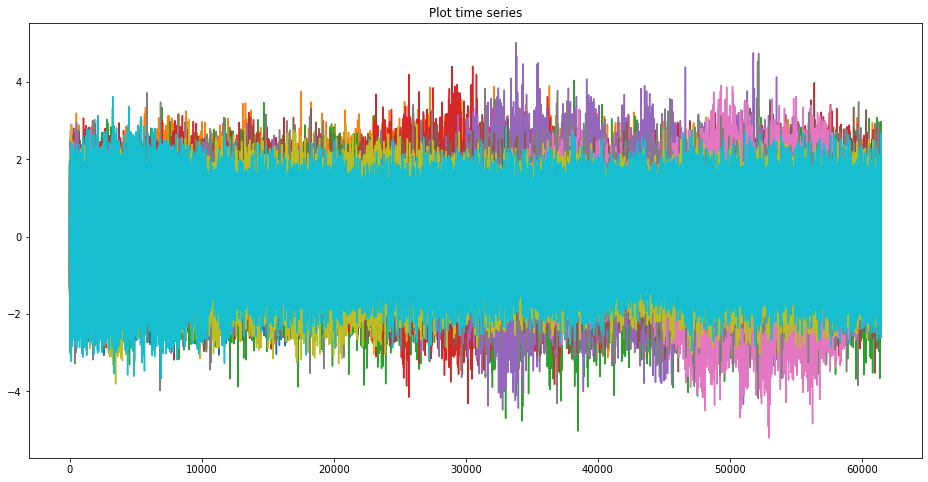

In [68]:
plt.figure(figsize=(16,8))
for i in range(n_obs):
    plt.plot(range(TimeseriesData.length), train_dataset.to('cpu')[:, 0, i])

title = 'Plot time series'
_ = plt.title(title)